In [1]:
import geopandas as gpd
import requests
from PIL import Image as PILImage
from PIL import ImageChops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from IPython.display import Image as IPyImage
import matplotlib.animation as animation
from scipy.ndimage import label
from matplotlib import cm
import matplotlib.lines as mlines
import LandUseChangeAnalyzer as LUCA

In [2]:
# FUNKCJE DO WYKRESÓW
def calculate_land_use_trend(class_percentage_per_year, area_name, show_plot=True,show_percent=True):
    trend = []

    for year, counts in class_percentage_per_year.items():
        row = {"Year": year}
        for class_label, percent in counts.items():
            row[class_label] = percent
        trend.append(row)

    trend_df = pd.DataFrame(trend).set_index("Year").fillna(0).sort_index(axis=1)

    if show_plot:
        ax = trend_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')

        # Dodaj wartości liczbowo nad każdym 
        if show_percent:
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%', fontsize=8, label_type='edge',rotation=45)

        plt.title(f"Zmiany użytkowania terenu w {area_name.replace('_', ' ').title()}")
        plt.xlabel("Rok")
        plt.ylabel("Udział (%)")
        plt.xticks(rotation=45)
        plt.legend(title="Typ terenu", bbox_to_anchor=(1.05, 1), loc='upper left')
        #plt.tight_layout()
        ax.grid(True)
        plt.show()
    


    return trend_df

def PrintImageForYear(year,images_dict,legend_dict_per_year,area_name,level_name,ax_map=None,ax_legend=None):
    if ((ax_map == None) or (ax_legend == None)):
        fig, (ax_map, ax_legend) = plt.subplots(ncols=2, figsize=(10, 5),gridspec_kw={'width_ratios': [3, 1]})
    pil_img = images_dict[year]
    year_legend = legend_dict_per_year[year]

    # Mapa
    ax_map.imshow(pil_img)
    ax_map.axis("off")
    title = area_name.replace("_", " ").title()
    ax_map.set_title(f"Mapa użytkowania terenu poziom {level_name} - {title} ({year})")

    # Legenda
    ax_legend.axis("off")
    ax_legend.set_title("Legenda", fontsize=12, fontweight='bold')

    legend_patches = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            markersize=10,
            markerfacecolor=np.array(rgb) / 255.0,
            label=label
        )
        for rgb, label in year_legend.items()
    ]

    ax_legend.legend(
        handles=legend_patches,
        loc="upper left",
        fontsize=9,
        frameon=False
    )


def MapAnimationByYears(images_dict, legend_dict_per_year, area_name, level_name, save_as_gif=True, fps=1):
    years = list(images_dict.keys())
    fig, (ax_map, ax_legend) = plt.subplots(ncols=2, figsize=(10, 5),gridspec_kw={'width_ratios': [3, 1]})

    def update(frame):
        ax_map.clear()
        ax_legend.clear()
        year = years[frame]
        PrintImageForYear(year,images_dict,legend_dict_per_year,area_name,level_name,ax_map=ax_map,ax_legend=ax_legend)

    ani = animation.FuncAnimation(
        fig, update,
        frames=len(years),
        interval=int(1000 / fps),
        repeat=True,
        blit=False
    )

    gif_filename = f"animacja_mapy_{level_name}.gif"
    if save_as_gif:
        ani.save(gif_filename, writer="pillow", fps=fps)
        plt.close(fig)
        return IPyImage(filename=gif_filename)
    else:
        return ani
    
def seperate_classes (level_classes, years, dfs,class_lvl,area_name):
    results = []

    for level_type in level_classes:
        for year in years:
            df = dfs[year]

            height = df['y'].max() + 1
            width = df['x'].max() + 1

            mask = np.zeros((height, width), dtype=np.uint8)
            x = df['x'].to_numpy()
            y = df['y'].to_numpy()
            classes = df[class_lvl].to_numpy()
            mask[y, x] = (classes == level_type).astype(np.uint8)

            labeled, num_features = label(mask)
            results.append({
                "year": year,
                "class": level_type,
                "count": num_features
            })

    data =pd.DataFrame(results)
    df_islands_pivot = data.pivot(index='year', columns='class', values='count')
    df_islands_pivot.plot(kind='line', figsize=(10, 6), marker='o')
    plt.title(f"Liczba wysp w {area_name.replace('_', ' ').title()} w latach {years[0]}-{years[-1]}")
    plt.xlabel("Rok")
    plt.ylabel("Liczba wysp")
    plt.xticks(years, rotation=45)
    plt.legend(title="Typ terenu", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show() 

In [3]:
LUCA.print_available_bounding_boxes()

EUROPA_OBSZARY_BBOX
Berlin
Paryż
Rzym
Amsterdam
Barcelona
Praga
Wiedeń
Oslo
Madryt
Lizbona
Kopenhaga
Bruksela

POLSKA_OBSZARY_BBOX
Warszawa
Gdańsk
Wrocław
Poznań
Rzeszów
Lublin
Szczecin
Katowice
Białystok
Łódź


In [4]:
Bialystok = LUCA.AreaManager("Białystok")

https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC1990_WM/MapServer/export
Obraz dla roku 1990 wczytany
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2000_WM/MapServer/export
Obraz dla roku 2000 wczytany
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2006_WM/MapServer/export
Obraz dla roku 2006 wczytany
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2012_WM/MapServer/export
Obraz dla roku 2012 wczytany
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2018_WM/MapServer/export
Obraz dla roku 2018 wczytany
Pobrano wszystkie obrazy.


In [5]:
Bialystok.prepare_analytical_data()

-----TWORZENIE DATAFRAME-----

DataFrame dla roku 1990 utworzony.
DataFrame dla roku 2000 utworzony.
DataFrame dla roku 2006 utworzony.
DataFrame dla roku 2012 utworzony.
DataFrame dla roku 2018 utworzony.
Obliczono wszystkie DataFrame.

------ZLICZENIA KLAS------

Zliczenia klas dla roku 1990 utworzone.
Zliczenia klas dla roku 2000 utworzone.
Zliczenia klas dla roku 2006 utworzone.
Zliczenia klas dla roku 2012 utworzone.
Zliczenia klas dla roku 2018 utworzone.
Obliczono zliczenia dla każdego roku.

------ZLICZENIA PROCENTÓW------

Obliczono procentowy udział klas.

------UNIKALNE KLASY------

Wyznaczono unikalne kategorie.

------OBRAZY DLA NIŻSZYCH POZIOMÓW------

Obraz dla roku 1990 (rgb_lvl_1) utworzony.
Obraz dla roku 2000 (rgb_lvl_1) utworzony.
Obraz dla roku 2006 (rgb_lvl_1) utworzony.
Obraz dla roku 2012 (rgb_lvl_1) utworzony.
Obraz dla roku 2018 (rgb_lvl_1) utworzony.
Obraz dla roku 1990 (rgb_lvl_2) utworzony.
Obraz dla roku 2000 (rgb_lvl_2) utworzony.
Obraz dla roku 2006 (rgb

In [6]:
# WYKRESY I ANALIZY

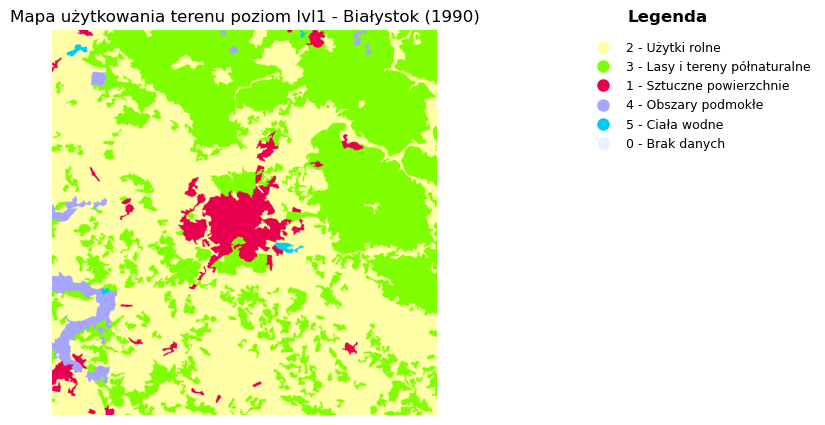

In [7]:
PrintImageForYear(1990,Bialystok.images_lvl_1, Bialystok.unique_categories_lvl_1_per_year, Bialystok.area_name, "lvl1")

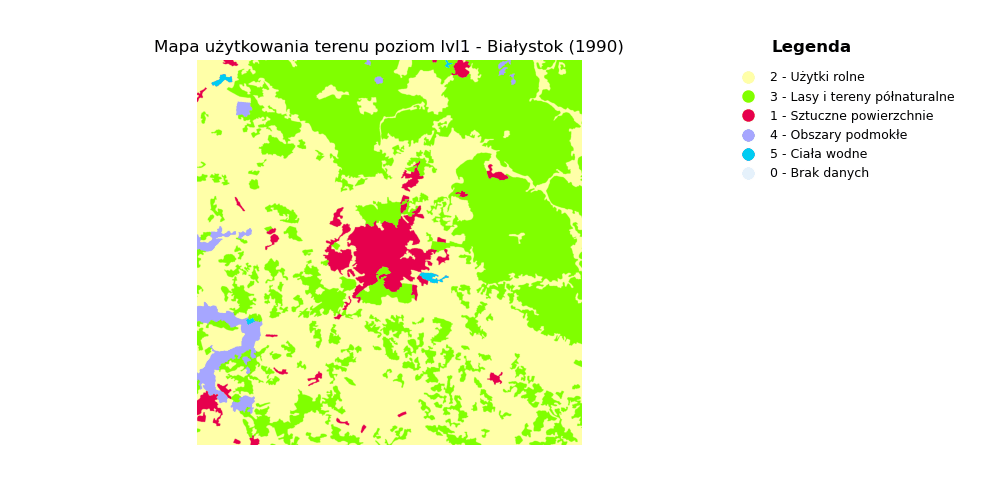

In [8]:
MapAnimationByYears(Bialystok.images_lvl_1, Bialystok.unique_categories_lvl_1_per_year, Bialystok.area_name, "lvl1")

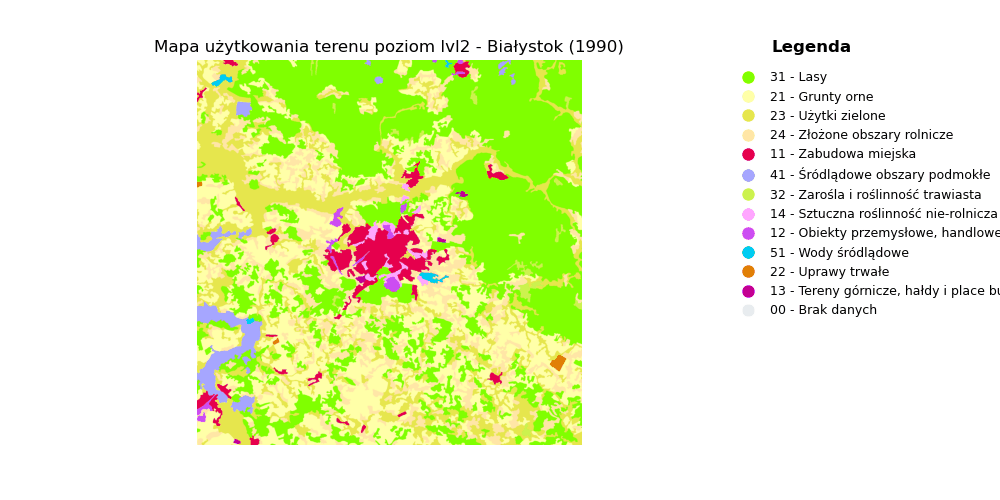

In [9]:
MapAnimationByYears(Bialystok.images_lvl_2, Bialystok.unique_categories_lvl_2_per_year, Bialystok.area_name, "lvl2")

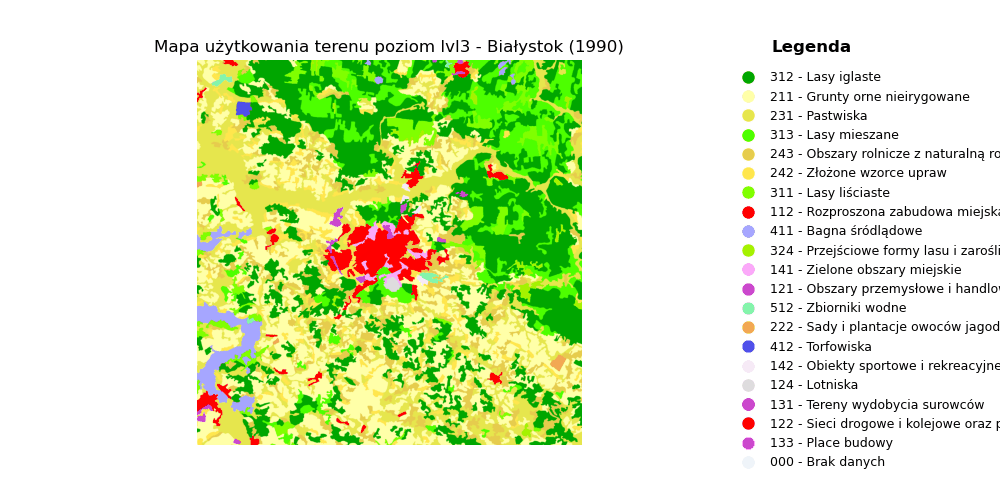

In [10]:
MapAnimationByYears(Bialystok.images_lvl_3, Bialystok.unique_categories_lvl_3_per_year, Bialystok.area_name, "lvl3")

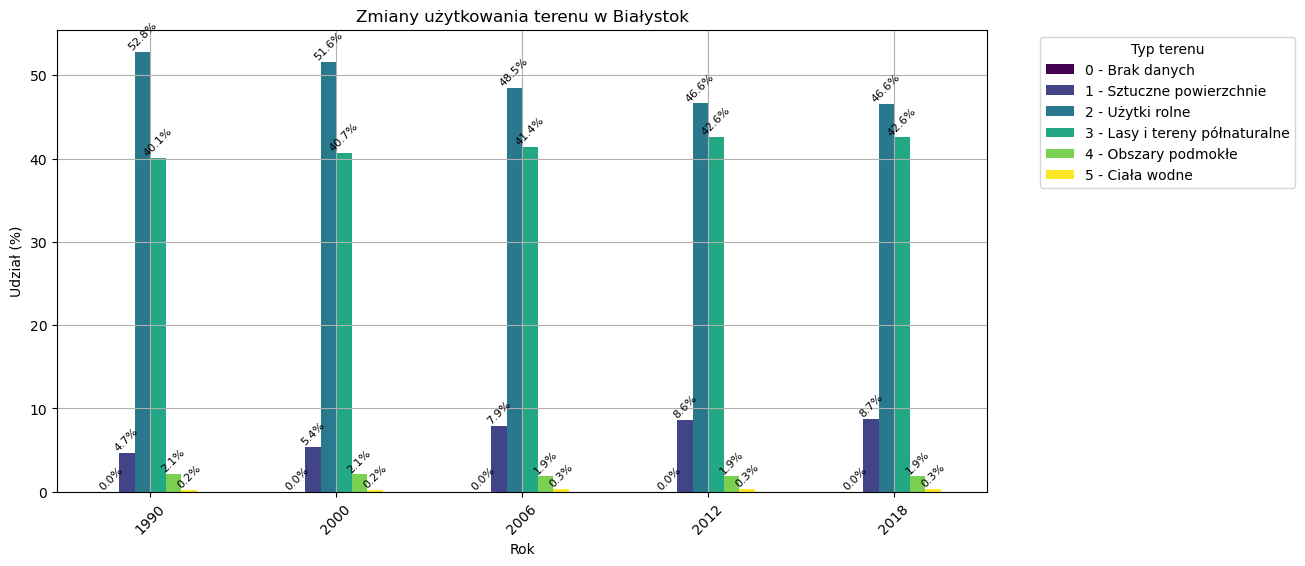

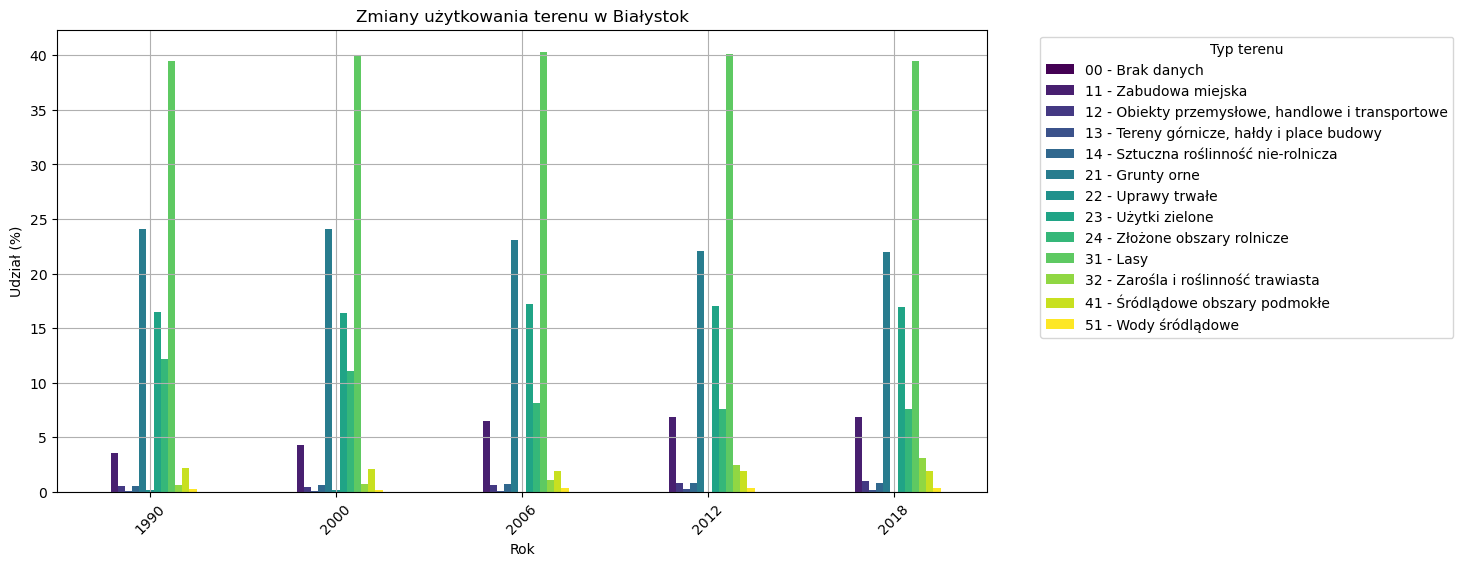

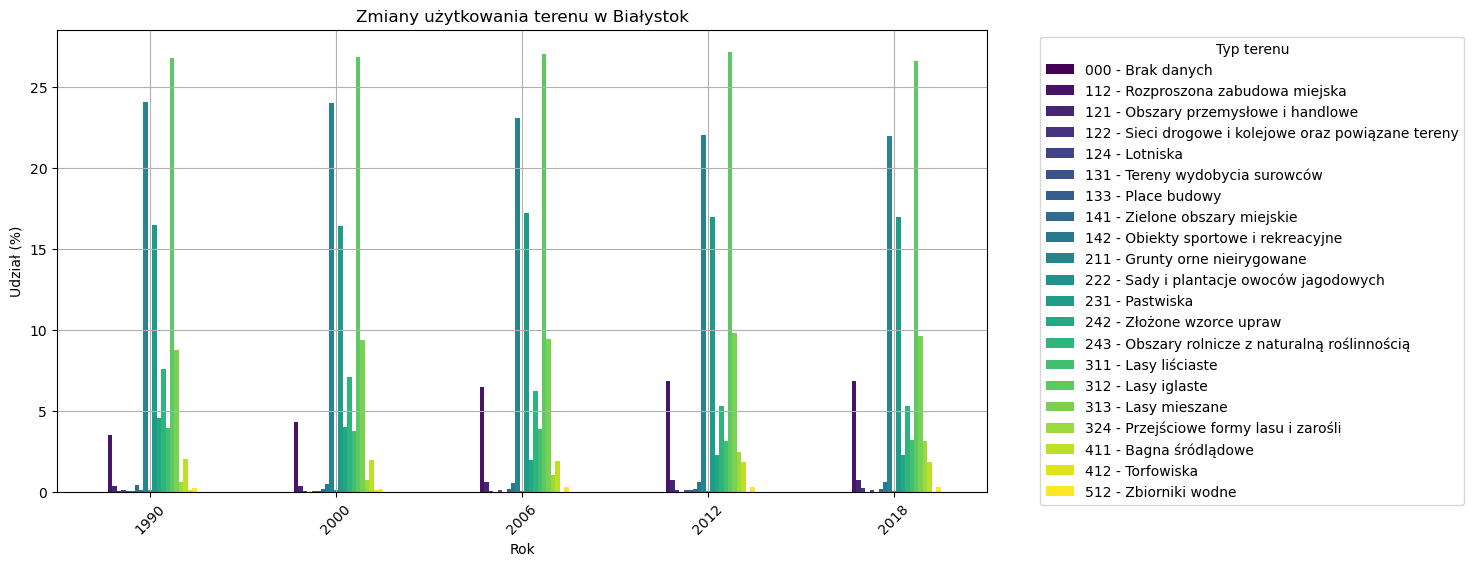

In [11]:
trend_lvl1 = calculate_land_use_trend(Bialystok.class_lvl_1_percentage_per_year, area_name=Bialystok.area_name,show_percent=True)
trend_lvl2 = calculate_land_use_trend(Bialystok.class_lvl_2_percentage_per_year, area_name=Bialystok.area_name,show_percent=False)
trend_lvl3 = calculate_land_use_trend(Bialystok.class_lvl_3_percentage_per_year, area_name=Bialystok.area_name,show_percent=False)

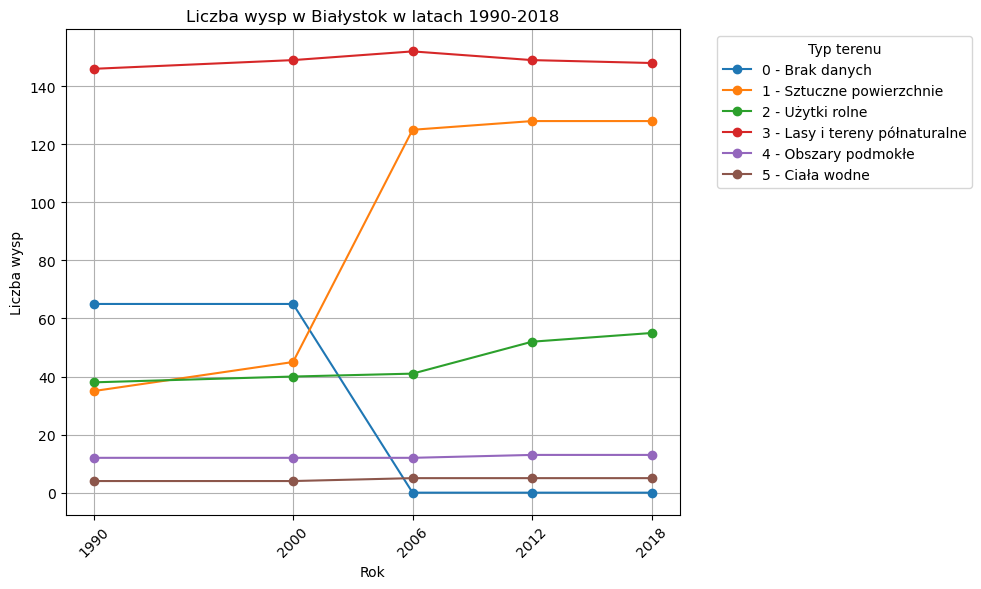

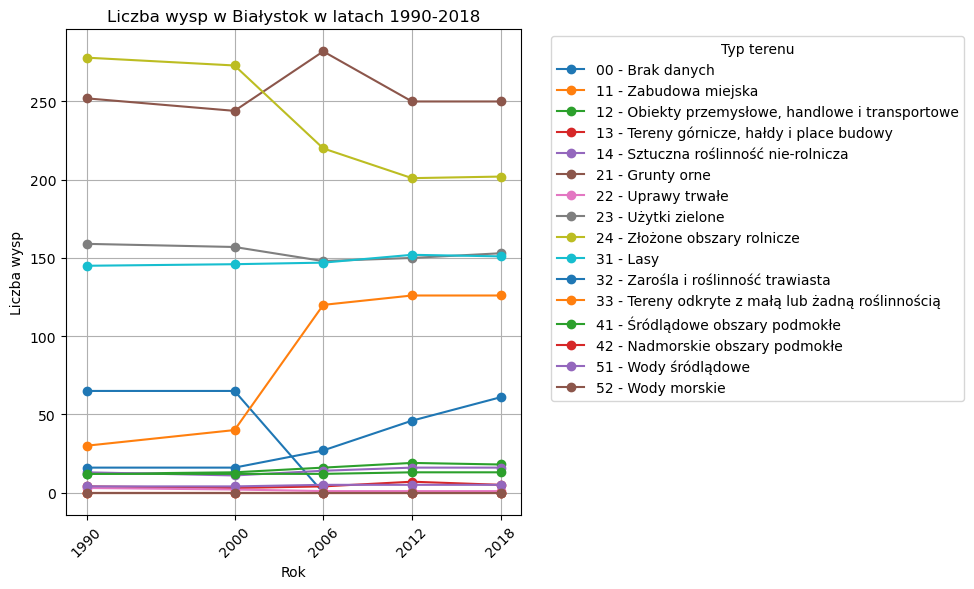

In [12]:
years = [1990,2000,2006,2012,2018]
df_islands_1 = seperate_classes(LUCA.level_1_legend_desc.values(), years, Bialystok.dfs,"class_lvl_1",Bialystok.area_name)
df_islands_2= seperate_classes(LUCA.level_2_legend_desc.values(), years, Bialystok.dfs,"class_lvl_2",Bialystok.area_name)